**Note on the imported packages.** At some point, we will use Naima here, and if I understand correctly, it requires Numpy v. < 2. But I had Numpy of the version 2...! So you can either downgrade Numpy to <2, or (what my best friend ChatGPT said to do) create an environment with Numpy < 2 and Naima installed (and some other packages which do not seem to be in conflict with Numpy or Naima). If you follow the second way, ensure that this Notebook is launched from the right environment. 

But if you just want to use IBSEn for Orbit / Winds & Stars / IBS / electron evolution and NOT for specta / light curves, you're good to go without Naima.

Here is a structure of a project. Plain text means there is a class for it; cursive means it's just a file with a bunch of functions.

![scheme_tot](ProjectScheme.png)

Suppose you want to calculate spectra at some moments of time [t1, .., tN]. You can create objects ``Orbit`` and ``Winds`` (both are stationary and currently do not allow time dependencies, though it's easy to fix) and then iterate over times, creating the intrabinary shock ``IBS``, the electron spectra on IBS ``ElectronsOnIBS``, and finally the photon spectra as a result of a non-thermal emission of electrons ``SpectraIBS``. As an alternative, you can create an object ``LightCurve`` that initializes all these objects for you and calculates a bunch of stuff, like fluxes in different wavebands at all times --- a light curve, essentially.


In [1]:
import numpy as np
from numpy import sin, cos, pi
import matplotlib.pyplot as plt
import time

import ibsen


DAY = 86400.
AU = 1.5e13


First, initialize the system you want to work with. I use the cartesian coordinate system with the origin in the optical star, the x-axis is directed to the periastron of the pulsar orbit, z-axis is directed as the angular velocity of the pulsar $\mathbf{\Omega}_{puls}$, y-axis is perpendicular to $x$ and $y$ directed so that $\mathbf{e}_x \times \mathbf{e}_y = \mathbf{e}_z$.

![coords](fig_orbit_coords.jpg)

For this, create a class ``orb:Orbit`` that would be passed as an argument in future to everything else. Once it is created, you can obtain some orbit parameters (orbital periond, eccentricity, etc.) or the arrays of coordinates (x, y, r, ...) along the orbit.

See Orbit_expanded for the full tutorial on all parameters and on what Orbit class can do and on all ways you can initiate an orbit.
Here, we show three ways of initializing an orbit without much explanation:
(1) with a keyword, (2) with parameters listed as a dictionary, and (3) with all parameters explicitly stated. 

**TODO: add the names of other gamma-ray binaries so they would be recognized.**

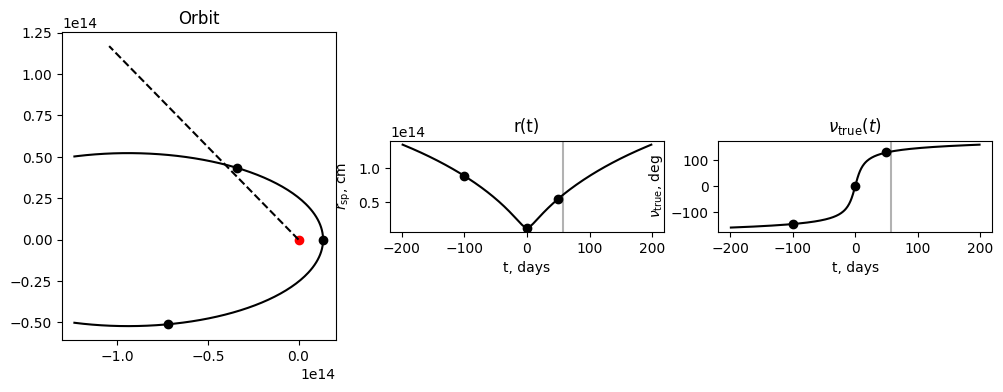

In [2]:
from ibsen.orbit import Orbit

"""
This is the simplest way of initializing an orbit: by a keyword sys_name = ...
The only available options are
(1) 'psrb' (PSR B1259-63), or
(2) 'rb' and
(3) 'bw' for typical values for redback and black widow spider pulsar systems.
"""

sys_name = 'psrb' 
orb = Orbit(sys_name = sys_name, n=1003)
orb.peek(ax=None, # optional, for usage see further
         showtime=[-200*DAY, 200*DAY], # which part of the orbit to display
         times_pos = [-100*DAY, 0, 50*DAY], # time points at which to display a dot on the orbit
         xplot = 'time', # whether x-axis is time [days]  or phase (then xplot = 'phase')
         color='k')

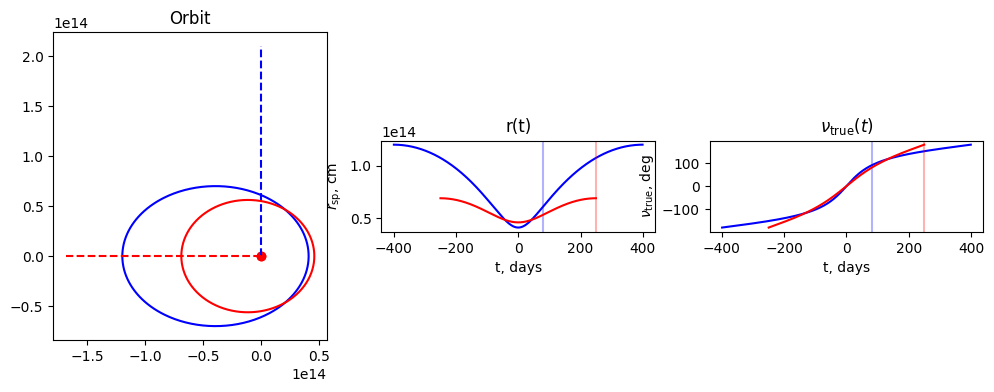

In [3]:

"""
You also can pass T , e, M, nu_los, incl_los as arguments, and these 
explicitly provided parameters will overwrite the default ones:
"""

orb_new = Orbit(sys_name = sys_name, T = 800. * DAY, e = 0.49, nu_los=pi/2.)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
orb_new.peek(ax=ax, color='b')

"""
Finally, you can initialize the orbit by providing the dictionary with the following keywords.
"""

orb_my_dict = {
             'e': 0.2, # eccentriciry. Necessary for orbit
             'M': 30. * 2e33, # total mass m1 + m2 [g]. The code does NOT check that M = Mopt + M_ns. Necessary for orbit
             'T': 500 * DAY, # the orbital period [s]. Necessary for orbit
             'nu_los': pi, # the angle between the star-to-periastron direction
             # and the direction to the observer (= 3pi/2 - \omega) [rad]
             # Necessary for orbit.

             'Ropt': 12 * 7e10, # the optical star radius [cm]. Necessary for winds (later)
             'Topt': 3.4e3, # the optical star effective temperature [K]. Necessary for winds (later)
             'Mopt': 28.6 * 2e33, # the optical star mass [g]. Necessary for winds (later)
             'D': 3e3 * 3e18, # the distance to the system [cm]. Necessary for spectrum (later)
             'M_ns': 1.4 * 2e33, # the neutron star mass [g]. Not necessary, can be skipped
           }

orb_my = Orbit(sys_params = orb_my_dict,
              allow_missing=True      ) #### If you explicitly set something as an argument here,
                                        ### e.g. T=700*Day,
                                        #### it overrites the value from the dictionary

orb_my.peek(ax=ax, color='r')


Now, let us initialize the winds with the class ``winds:Winds``. Quick remark: Apart from outflows-related stuff, I temporarily put everything related to the properties of an NS (P, meaning ''pulsar'') and an optical star (S, meaning ''Star'') in this class: so temperature/radius of S, magnetic fields as functions of r (**TODO**) --- are all initialized/calculated here.  In this class, there are also their magnetic fields and functions for calculating them at some distance and at the shock apex (at time $t$) and the same for the photon field of the optical star. 

Anyway, about the outflows. See the tutorial `Winds_expanded` for an overview of models I use for winds. Shortly, the pulsar wind is assumed spherically symmetrical; the Be outflows consist of a spherically-symmetric polar wind and a decretion disk in a rotation plane of the Be-star.

Here you can also calculate the distance at which $P_w + P_d = P_p$ and calculate the effective relation between winds momenta at the moment of time after the periastron passage $t$.



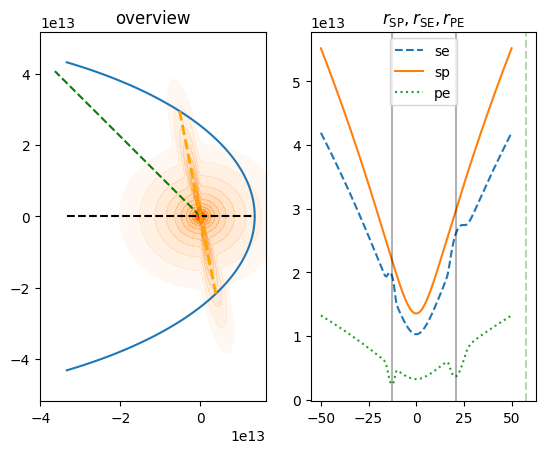

In [4]:
from ibsen.winds import Winds

# having initialized orb:Orbit, initialize winds:Winds

winds = Winds(orbit=orb, sys_name = sys_name, alpha=10/180*pi, incl=23*pi/180,
              f_d=165, f_p=0.1, delta=0.01, np_disk=3, rad_prof='pl', r_trunk=None,
             height_exp=0.25, p_enh=[1,], p_enh_times=[0,], t_forwinds=1)
winds.peek(ax=None,
           showtime = (-50*DAY, 50*DAY), # optional. Default is (-T/2, T/2)
           plot_rs = True # whether to plot the dependence of r_pe/se/sp on time
          )


Now it's time for the intrabinary shock (ibs) from class IBS. I use the model from Canto, Raga, and Wilkin

https://ui.adsabs.harvard.edu/abs/1996ApJ...469..729C/abstract

in which (if coordinates are in units of birary separation) the shock shape depends only on one parameter $\beta$, the relation between the pulsar and the optical star _spherical_ winds momenta. 

To initialize the IBS, you need ``beta`` (float) and ``s_max`` which defines where the shock ends.

**TODO: or a string ''bow'' (then only such part of the IBS left that $\theta \leq 90^\circ$), or a string ''incl'' (then only such part of the IBS left that the angle between the tangent and the direction to the pulsar is $\leq 90^\circ + 10^\circ$).**

There are two IBS classes. The first one, IBS_norm, works only with dimentionless units (all lengths are normalized to the binary separation, so that $r_{sp}=1$. The second one accepts winds:Winds along with the time at which to set IBS, and calculates the effective $\beta$ from the pressure balance equations. 

First, I demonstrate how IBS_norm works. It accepts $\beta$, s_max, and parameters of bulk motion of matter along the shock s_max_g and $\Gamma_\mathrm{max}$:

\begin{equation}
    \Gamma(s) = 1 + (\Gamma_\mathrm{max}-1)\frac{s}{s_\mathrm{max~g}}
\end{equation}

You can also rotate the shock at any angle, calculate doppler factors, photon scattering angle (from star - to IBS - to the observer), and the same angle in the frame co-moving with the matter. Upon initializing, the class obtains the values x, y, s (arclength from apex to the given point), r, theta, r1, theta1, tangent (the angle between the tangent to a given point and the x-axis), thetainf (the max angle theta), and x_apex (the distance from the pulsar to the IBS apex). Also defined are: x, y, s, theta in the segments centers.


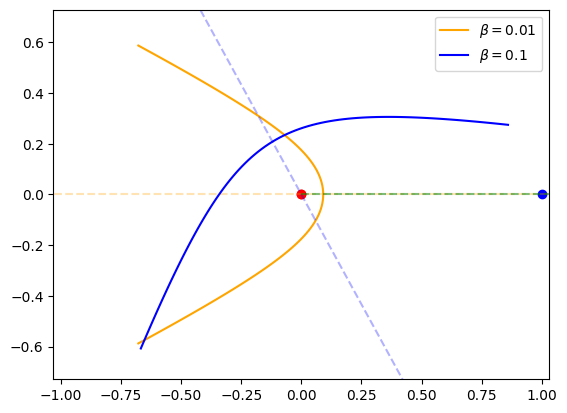

In [5]:
from ibsen.ibs import IBS
from ibsen.ibs_norm import IBS_norm
## draw two rotated shocks, in dimentionless units.
fig, ax = plt.subplots(1, 1)
beta1 = 0.01
ibs1 = IBS_norm(beta=beta1, n=51, s_max = 1, gamma_max=2, s_max_g=1)

ibs1.peek(ax=ax, ibs_color='orange', to_label=True)
beta2 = 0.1
ibs2 = IBS_norm(beta=beta2, n=51, s_max = 1, gamma_max=2, s_max_g=1).rotate(120*pi/180)
ibs2.peek(ax=ax, ibs_color='blue', to_label=True)


Class ``IBS`` deals with the IBS in real units. You need to provide the Winds object together with a time relative to a periastron psssage, so the effective $\beta$ at that moment will be calculated.

/home/alvkuzin/whole_psrb_project/src/ibsen/ibs.py:442: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


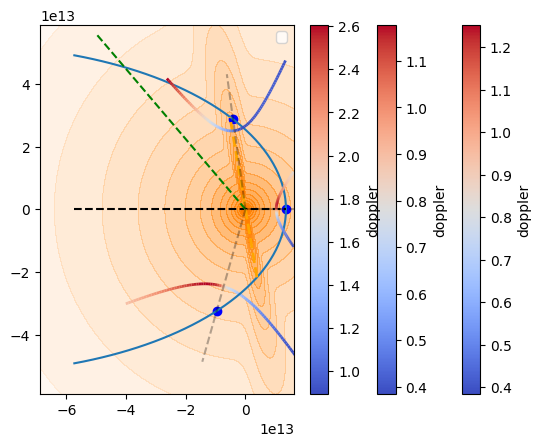

In [6]:
##### For t = 25 days, 0, and 20 days, draw an IBS calculated from the winds initialized
##### before. Draw it with color corresponding to the doppler factor delta.

fig, ax = plt.subplots(1, 1)
show_winds = True
for t in (-25*DAY, 0*DAY, 20*DAY):
    ibs = IBS(winds = winds,    # previously initialized class winds:Winds to calculate beta_eff
              gamma_max=3.,     # max bulk motion gamma
              s_max=1.,         # where to cut IBS. s_max = 1 means 'cut it where the arclength
                                # along the shock is equal to the 1 orbital separation at a given time'
                                # can also be strings ``bow`` or ``incl``.
        
              s_max_g=4,        # a parameter of a linear function Gamma(s) 
              n=41,             # number of points in ONE horn of IBS to initialize
        
              
              t_to_calculate_beta_eff=t  # when to calculate beta_eff
              )
    # show winds once
    ibs.peek(fig=fig, ax=ax,
                  show_winds=show_winds, # self-explanatory. winds:Winds should be provided. Default is False.  
                  ibs_color='doppler', # either real color to put to matplotlib OR {'doppler', 
                                         # 'scattering', 'scattering_comoving'}.
                  showtime = (-80*DAY, 80*DAY), # to put into winds.peek()
                  to_label = False,
                 )
    show_winds = False
 
                                                 
# ax.set_xlim(-0.5e14, 0.3e14)                                             
# ax.set_ylim(-orb.b*1.2, orb.b*1.2)

Now it's time to do something useful. Let's calculate the spectrum of relativistic electrons in each point of IBS that we have just initialized. There are many parameters that you should/may specify for this, so the full list is in the example below right in the Python code, with descriptions and default values. Here's a short desctiption, see ``ElectronEvolution_expanded`` tutorial for the more complete explanation.

First of all, you can set ``cooling='no'``, and the spectrum of electrons in each $s$ will be (numerically) set to the injection function $Q_\mathrm{inj}(s, E)$. Note that from the physical point of view this is nonsense, as $Q$ is the number of $\mathrm{e}^-$ injected per unit of time (per cm per eV) ($\mathrm{s}^{-1}$), so $Q\times (E/\dot E)$ gives the numer of particles (per cm per eV), but setting ``cooling='no'`` ignores the dimentions difference and just sets $n(s, E) \equiv Q(s, E)$.

All other options allow to find an electron spectrum $n(s, e) = d\dot N_e/ds/de$. 

- ``cooling='stat_apex'`` calculates the stationary e-spectrum on each $s$ using magnetic and photon fields as in the IBS apex;
- ``cooling='stat_ibs'`` calculates the stationary e-spectrum on each $s$ using magnetic and photon fields in this point on IBS;
- ``cooling='stat_mimic'`` calculates the stationary e-spectrum on each $s$ with the ''adiabatic time'' $t_a$ calculated to mimic the ''proper'' advection equation solution;
- ``cooling='adv'`` solves the 2-dimentional advection-over-s + coooling-over-e equation with the same $\dot E$ as before but without ''advection losses''.
  **And experimental options:**
 - ``cooling='leak_apex'``,
 - ``cooling='leak_ibs'``,
 - ``cooling='leak_mimic'``.
The names have the same meaning as for ``stat`` options, but the equation with leakage is being solved instead.

The IBS you provide should be ``ibs:IBS`` class, not ``ibs:IBS_norm``.

At the moment of initializing the class, the spectra $n_e(s,E)$ are not calculated yet (as the calculation may take a while but you maybe just want to know how the magnetic field is distributed along the shock and don't care for e-spectrum). To actually calculate $n_e$, you should do  ``els.calculate()``.

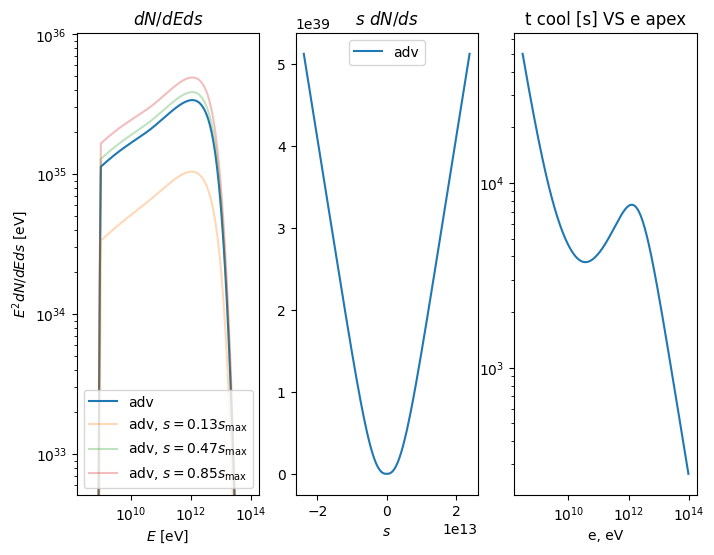

In [7]:
from ibsen.el_ev import ElectronsOnIBS

##### let's again initialize an IBS at, say, 15 days after periastron. Let's do that for three different 
##### models of cooling: stat_ibs, stat_mimic, and adv.
t = 15 * DAY
Nibs = 141
ibs = IBS(winds=winds,
          gamma_max=3.,
          s_max=1.,
          s_max_g=4.,
          n=Nibs,
          t_to_calculate_beta_eff=t) # the same IBS as before
els = ElectronsOnIBS(
                     Bp_apex=0.2, # The magnetic field [G] in the Apex of the IBS coming from pulsar. Mandatory.
                     ibs=ibs, # The IBS at which the e-spec should be calculated. Mandatory.
                     cooling='adv', # How to cool the particles. Default is 'no'.
                     to_inject_e = 'ecpl', # The injection spectrum keyword. Current options: 'ecpl' (default) or 'pl'.
                     to_inject_theta = '3d', # If '2d', then injection distribution over theta is uniform. 
                                             # If '3d' (default), then \propto sin(theta). 
    
                     ecut = 5.e12,  # Cutoff energy [eV] for ecpl. Default is 1e12.
                     p_e = 1.8, # the injection spectrum index. Default is 2.
                     to_cut_e = True, # If to set injecttion spectrum to 0 outside of the band emin < e < emax. Default is True.
                     emin = 1e9, # If to_cut_e == True, then it is the min e-energy of inj spectrum [eV]. Default is 1e9. 
                     emax = 5e13, # If to_cut_e == True, then it is the max e-energy of inj spectrum [eV]. Default is 5.1e14. 
                     emin_grid=3e8, # min of the energy grid. Default is 1e8.
                     emax_grid=1e14, # max of the energy grid. Default is 5.1e14.
    
                     norm_e = 1.e37, # the overall normalization of the injection spectrum. Default is 1e37. 
                                     # if cooling != 'no', then norm_e is treated as total number of injected e- / second.
    
                     Bs_apex=0., # The magnetic field [G] in the Apex of the IBS coming from opt. star. Default is 0.
                     eta_a = 1e20, # t_a = eta_a * dist/c. Can be either a float of None. If None, then the value
                                    # 1e20 is used. It is hardcoded that any value above 1e10 is essentially infinity,
                                    # so if you want no adiabatic losses, pass either eta_a > 1e10 or eta_a = None.
                                    #    Default is None.
    
                     eta_syn = 1., # coef before synchrotron losses term. Default is 1.
                     eta_ic = 1., # coef before IC losses term. Default is 1.
                     to_cut_theta =  False, # If to inject only at theta < where_cut_theta.
                     where_cut_theta = pi/2, # If to_cut_theta == True, then non-zero injection is only at theta < where_cut_theta.
                                             # Default if pi/2. 
                     ) 
dNe_de_IBS, e_vals = els.calculate(to_return=True        # If to return 2d-spectra (on s_grid x e_vals) and e_vals. Default is False.
                                       )
els.peek()

Now it's close to finish: let's calculate the spectrum of the IBS. We know its shape, we know everything about electrons emitting, so we can calculate the Synchrotron and inverse Compton emission. This is done using Naima code, so you should have it installed. There are three modes of calculation of an SED which are controlled by two boolean keywords: `apex_only` and `simple`.
 - `apex_only=True` (any `simple`) means calculating the SED using the $B/u$ values in the IBS apex,
 - `apex_only=False`, `simple=True` means calculate SED in apex and rescale it in a simplified manner for all segments on the IBS,
 - `apex_only=False`, `simple=False` means iterate along the IBS and calculate the SED in every segment properly and independently.

As before, see `SpectrumIBS_expanded` tutorial for the particulars of the calculations.


index in 3-10 keV =  1.448647779223692
Swift 0.3-10 keV flux is 6.391056706424584e-13
H.E.S.S. 0.4-10 TeV flux is 2.4698167061729114e-11


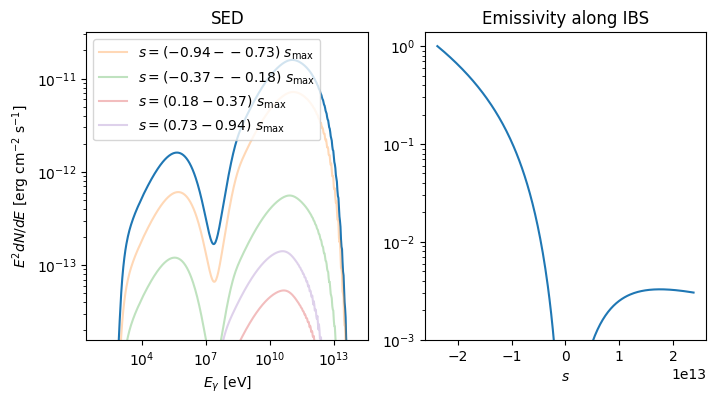

In [8]:
from ibsen.spec import SpectrumIBS

spec = SpectrumIBS(sys_name=sys_name,
                   els=els, # els:ElectronsOnIBS class. Mandatory
                   simple=True, # Whether to calculate the spectrum in a simple fashion (see above). Default is False.
                   mechanisms=['syn', 'ic'], # what radiation mechanisms to use
                   apex_only=False,
                   delta_power=3, # The power p_delta (see above). Default is 4.
                   lorentz_boost=True, # Whether to perform Lorentz boost B, u_g, and n(s, E). Default is True.
                                       # If simple=True was set, the e-spectrum
                                       # n(s, E) will not be transformed, but the s-averaged spectrum (in lab frame) will be used instead. 
                   
                   abs_photoel=True, # Whether to include the TBabs-like photoelectric absorbtion. Default is True.
                   nh_tbabs=0.8, # If abs_photoel=True, this is the N_H (in units of 10^22) to use. Default is 0.8. 
                   abs_gg=True, # Whether to include the gamma-gamma absorbtion. Experimental feature, only for PSR B1259-63,
                                 # since it uses the tabulated values.
                   
                   distance = None # The distance to the system [cm]. Default is None. It will try to get the distance from the 
                                   # parameters that you provided for orbit:Orbit, but distance=<some_float> overwrites it.
                  )


E_ = np.logspace(2, 14, 500) 
(e_ph_here, # the grid of photon energies. It should be = E_, but I'm not sure hahhaaaa
 sed_here, # the total SED from IBS: 1-d array of length len(e_ph_here)
 sed_s_here # the SED from each point on IBS. 2-d array of shape (len(ibs.s), len(e_ph_here))
) = spec.calculate_sed_on_ibs(to_return=True, # If to return SED. Default is False
                                     E = E_ # On which energies to calculate the spectrum. Default is np.logspace(2, 14, 1000).
                                     )
spec.peek()


#### Calculate the index of the spectrum in Swift energy range. 
#### To avoid effects of absorbtion, perform fitting over (3, 10) keV.
G_ind_swift = spec.index(e1 = 3e3, e2 = 1e4)
print('index in 3-10 keV = ', G_ind_swift)

########### Calculate fluxes in keV and TeV ranges.
fl_swift, fl_hess = spec.fluxes( bands = (
                                          [3e2, 1e4],
                                          [4e11, 1e13]
                                         )
                               )
print('Swift 0.3-10 keV flux is', fl_swift)
print('H.E.S.S. 0.4-10 TeV flux is', fl_hess)

I imagine you can be bored with initializing all these classes. If you just want one function to calculate the light curve, even if for just one moment of time, here is the function for that. What it does it:
 - initializes ``orbit:Orbit`` and ``winds:Winds`` classes 
 - for every moment of time, initializes ``ibs:IBS``, ``els:ElectronsOnIBS``, and ``spec:SpectrumIBS`` classes (and calculates everything)
 - stores everything.

**TODO** I have to write the interpolator for getting the approximate values of everything in any moment of time.

In [9]:
from ibsen.lc import LightCurve
t1 = np.linspace(-650, -60, 40) * DAY
t2 = np.linspace(-50, 90, 60) * DAY
t3 = np.linspace(100, 650, 40) * DAY
#ts = np.concatenate((t1, t2, t3))
ts=t2
lc = LightCurve(sys_name = 'psrb',
                n_ibs = 13,
                p_e = 2.0,
                times = ts,
                bands = ([3e2, 1e4], [4e11, 1e13],
                        ),
                ### next two rows mean: starting from t=t2 (second disc passage), increase the disc height 3 times.
                h_enh=[3,],
                h_enh_times=['t2',], # can contain floats (e.g. 10*DAY) or str {'t1', 't2'}. The list should be in ascending order,
                                     # e.g. [-50*DAY, 't1', 5*DAY, 't2' ] is OK for PSRB, while ['t2', -50*DAY] is not.
                bands_ind = ([3e3, 1e4],),
                full_spec = True,
                to_parall = True, 
                f_d = 150,
                mechanisms=['syn', 'ic'
                           ],
                ic_ani=False, # you can use it, but anisotropic calculation has some problems
                simple = True,
                apex_only=False,
                alpha_deg = 8.,
                s_max = 1,
                gamma_max=1.1,
                delta=0.015,
                cooling='stat_mimic',
                eta_a=0.1, # you may want to set that to 1e20 if cooling='adv'
                ns_b_ref=0.5,
                ns_r_ref=1e13,
                abs_gg=True,
               )
start = time.time()
lc.calculate()
print(f'LC done in {time.time() - start}')


LC done in 3.1173949241638184


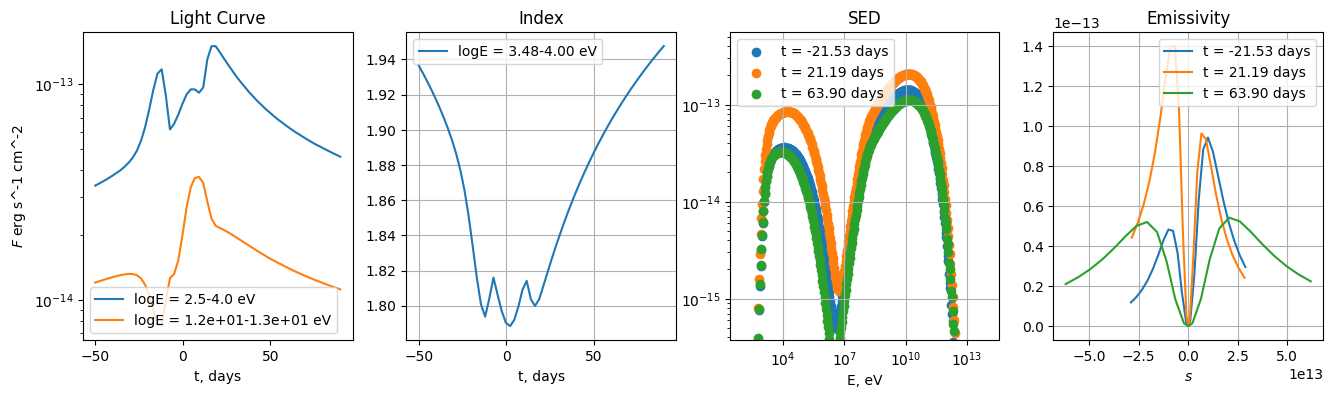

In [10]:
lc.peek()

LC done in 5.5932464599609375
LC done in 5.2810914516448975
LC done in 6.1093809604644775
LC done in 6.189305067062378


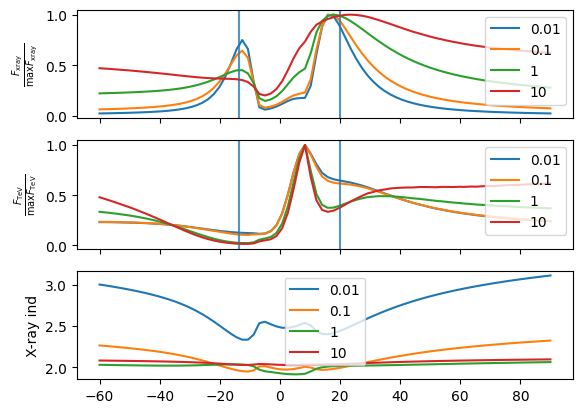

In [13]:
from ibsen.lc import LightCurve
"""
Finally, let's take a look at how the light curves change for various magnetic fields.

We assume that the overall normalization is more or less unfixed, and can always be fitted
using the observational data, so we normalzie all light curves to their max values at -30d < t < 50d.
"""

fig, ax = plt.subplots(nrows=3, sharex=True)

t1 = np.linspace(-300, -70, 70) * DAY
t2 = np.linspace(-60, 90, 80) * DAY
t3 = np.linspace(100, 300, 70) * DAY
#ts = np.concatenate((t1, t2, t3))
ts=t2
#for cooling in ('stat_mimic', 'adv'):
for field in (0.01, 0.1, 1, 10):
    lc1 = LightCurve(sys_name = 'psrb',
                    n_ibs = 13,
                    p_e = 2,
                    times = ts,
                    bands = ([3e2, 1e4], [4e11, 1e13]),
                    bands_ind = ([3e3, 1e4],),
                    epows = (1, 0), # which moment of dN/de to use for the flu calculation. 
                                    # 1 means \int E dN/dE dE = flux, while 0 means \int dN/dE dE = N of photons
                    full_spec = False, 
                    apex_only=False,
                    to_parall = True, 
                    f_d = 500,
                    mechanisms = ['sy', 'ic'],
                    simple = False,# try changing to True, that will 10x increase the speed, but the calculation will be slightly incorrect.
                    alpha_deg = 8.,
                    s_max = 1,
                    gamma_max=1.5,
                    delta=0.02,
                    cooling='stat_mimic', # try changing to adv and change eta_a --> 1e10 (the calculation will be long)
                    eta_a = 1,
                    ns_b_ref=field,
                    ns_r_ref=1e13,
                    abs_gg=True
                   )
    start = time.time()
    lc1.calculate()
    print(f'LC done in {time.time() - start}')
    fluxes = lc1.fluxes
    fl_sw, fl_hess = fluxes[:, 0], fluxes[:, 1]
    cond_f = np.isfinite(fl_sw) & np.isfinite(fl_hess)
    fl_sw, fl_hess, ts = [ar[cond_f] for ar in (fl_sw, fl_hess, ts)]
    cond = np.logical_and(ts>-30*DAY, ts<50*DAY)
    ax[0].plot(ts/DAY, fl_sw/np.nanmax(fl_sw[cond]), label = field)
    ax[1].plot(ts/DAY, fl_hess/np.nanmax(fl_hess[cond]), label = field)
    tdisk1, tdisk2 = lc1.winds_classes[0].times_of_disk_passage
    for i_ in (0, 1):
        ax[i_].axvline(x=tdisk1/DAY, alpha=0.3)
        ax[i_].axvline(x=tdisk2/DAY, alpha=0.3)
    
    ax[2].plot(ts/DAY, lc1.indexes, label = field)
ax[0].set_ylabel(r'$\frac{F_\mathrm{xray}}{\mathrm{max} F_\mathrm{xray}}$')   
ax[1].set_ylabel(r'$\frac{F_\mathrm{TeV}}{\mathrm{max} F_\mathrm{TeV}}$')   
ax[2].set_ylabel(r'X-ray ind')   
ax[0].legend()
ax[1].legend()
ax[2].legend()

